In [ ]:
"""

1) load in dataframe
    -> Of importance : this contains the label (Family), FilePath, and View (of image taken)
2) dataframe filtered for DORSAL view
3) train-test-split with even numbers of each class

"""

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator

In [2]:
#NOTE - I am working in an nvidia-docker image with official tensorflow docker.
# I had to add this line AND 'trust' the notebook on top-right. Otherwise an ugly
# cudNN error is present.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
image_dir = '/home/jovyan/work/beetleData/images/'
label_csv = '/home/jovyan/work/beetleData/labels/master_rbi.csv'

In [4]:
labels = pd.read_csv(label_csv)
labels.head()

,Family:,Subfamily:,Country:,Province:,Genus:,Species:,View:,Filename:
0,Anthribidae,/,Equatorial Guinea,/,Phaeotragus,gigas,Dorsal,rbi_1.jpg
1,Anthribidae,/,Equatorial Guinea,/,Phaeotragus,gigas,Lateral,rbi_2.jpg
2,Anthribidae,/,Madagascar,/,Tophroderes,phrenatus,Dorsal,rbi_3.jpg
3,Brentidae,/,Indonesia,Sumatra,Eutrachelus,temmincki,Dorsal,rbi_4.jpg
4,Brentidae,/,Indonesia,Sumatra,Eutrachelus,temmincki,Dorsal,rbi_5.jpg


<AxesSubplot:>

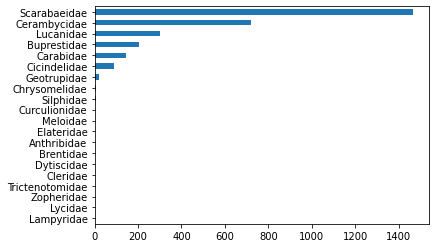

In [5]:
classify_column = 'Family:'

dorsal_data = labels[labels["View:"] == "Dorsal"] #filter images that are from dorsal view
dorsal_data[classify_column].value_counts().sort_values().plot(kind = 'barh') # preview the distribution

In [6]:
top_classes = 6
top6 = dorsal_data[classify_column].value_counts(normalize=True)[:top_classes]
top6

Scarabaeidae    0.492287
Cerambycidae    0.241449
Lucanidae       0.100604
Buprestidae     0.069081
Carabidae       0.048625
Cicindelidae    0.030181
Name: Family:, dtype: float64

<AxesSubplot:>

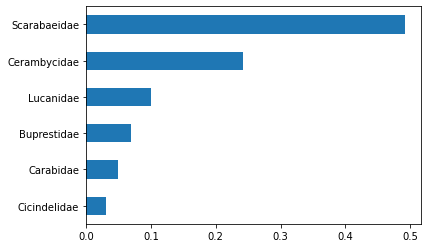

In [7]:
top6.sort_values().plot(kind = 'barh') # preview the distribution

In [8]:
print(top6)
print(top6.index)

Scarabaeidae    0.492287
Cerambycidae    0.241449
Lucanidae       0.100604
Buprestidae     0.069081
Carabidae       0.048625
Cicindelidae    0.030181
Name: Family:, dtype: float64
Index(['Scarabaeidae', 'Cerambycidae', 'Lucanidae', 'Buprestidae', 'Carabidae',
       'Cicindelidae'],
      dtype='object')


In [9]:
top6_df = dorsal_data[dorsal_data[classify_column].isin(list(top6.index))] #filter images from only top 6 classes
top6_df.tail()

,Family:,Subfamily:,Country:,Province:,Genus:,Species:,View:,Filename:
4057,Scarabaeidae,Scarabaeinae,Central African Republic,Haute-Sangha,Sisyphus,atratus,Dorsal,rbi_4233.jpg
4058,Scarabaeidae,Scarabaeinae,CÃ´te d'Ivoire,/,Sisyphus,biarmatus,Dorsal,rbi_4234.jpg
4059,Scarabaeidae,Scarabaeinae,Central African Republic,KÃ©mo,Sisyphus,gladiator,Dorsal,rbi_4235.jpg
4060,Scarabaeidae,Scarabaeinae,Central African Republic,KÃ©mo,Sisyphus,gladiator,Dorsal,rbi_4236.jpg
4061,Scarabaeidae,Scarabaeinae,/,/,Sisyphus,muricatus,Dorsal,rbi_4237.jpg


In [10]:
"""
train_test_splitter_even_across_labels

a function which takes a dataframe of data points, goes through each unique value in the label, and
randomly samples % for train/test split
"""
train_indexes = []
test_indexes = []
train_ratio = 0.8 # ****** IMPORTANT PARAMETER
get_labels = top6_df[classify_column].unique()
# loop through each label
count = 0
for label_type in get_labels:
    print(label_type)
    #subset the whole dataframe for the label_type
    subset_df = top6_df[top6_df[classify_column] == label_type]
    #split the rows randomly into a subset_test and subset_train dataframe
    number_samples = subset_df.shape[0] #total number of rows in dataframe
    df_split = pd.DataFrame(np.random.randn(number_samples,2))
    df_split = np.random.rand(len(df_split)) < train_ratio
    train = list(subset_df[df_split].index)
    test = list(subset_df[~df_split].index)
    train_indexes.append(list(train))
    test_indexes.append(list(test))
    
train_indexes = [item for sublist in train_indexes for item in sublist] # fancy way to flatten a list of lists
test_indexes = [item for sublist in test_indexes for item in sublist]

train_dataframe = top6_df.iloc[top6_df.index.isin(train_indexes)] # fancy way to subset a dataframe by list of indexes
test_dataframe = top6_df.iloc[top6_df.index.isin(test_indexes)]

Buprestidae
Carabidae
Cerambycidae
Cicindelidae
Lucanidae
Scarabaeidae


In [86]:
#important parameters
image_size = (128,128)
batch_size = 12

In [87]:
datagen=ImageDataGenerator(rescale=1./255)
classes = list(train_dataframe["Family:"].unique())
train_generator=datagen.flow_from_dataframe(dataframe=train_dataframe,
                                        directory=image_dir,
                                        x_col="Filename:", y_col="Family:",
                                        class_mode="categorical",
                                        classes = classes,
                                        target_size=image_size,
                                        batch_size=batch_size)

test_generator=datagen.flow_from_dataframe(dataframe=test_dataframe,
                                        directory=image_dir,
                                        x_col="Filename:", y_col="Family:",
                                        class_mode="categorical",
                                        classes = classes,
                                        target_size=image_size,
                                        batch_size=batch_size)

Found 2343 validated image filenames belonging to 6 classes.
Found 586 validated image filenames belonging to 6 classes.


In [88]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

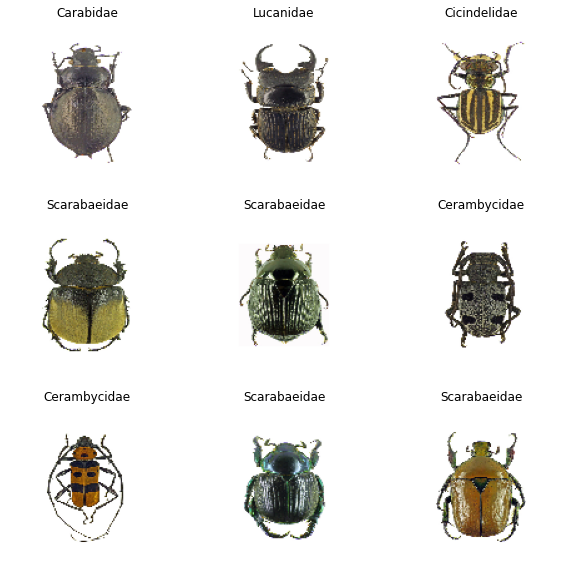

In [89]:
# Preview Dataset
plt.figure(figsize=(10, 10))
img,label=test_generator.next()
for i in np.arange(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i])
    plt.title(classes[np.argmax(label[i])])
    plt.axis('off')

In [90]:
augmented_image = data_augmentation(img)

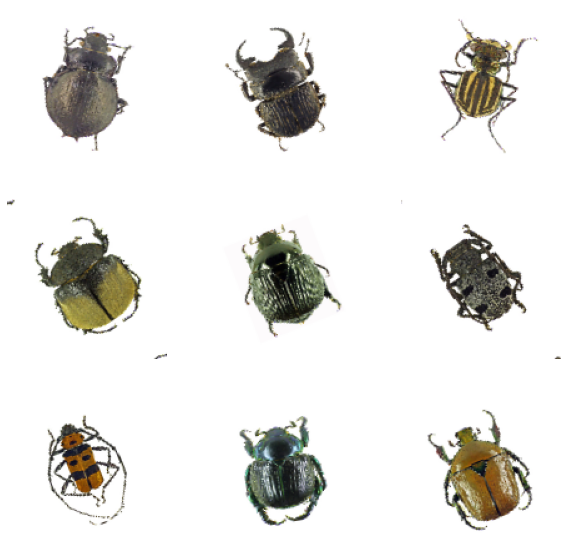

In [91]:
# Preview a batch of image augmentations
plt.figure(figsize=(10, 10))
img,label=test_generator.next()
for i in np.arange(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[i])
    plt.axis('off')

In [135]:
# this model is taken from https://keras.io/examples/vision/image_classification_from_scratch/

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    #x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=6)
keras.utils.plot_model(model, show_shapes=True)


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [136]:
filepath = !pwd
filepath = filepath[0] + '/models/'
print(filepath)

/home/jovyan/work/github/beetle-vision/models/


In [137]:
# CALLBACKS : This will determine which models are saved during training.

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath + "save_at_{epoch}.h5",
                                   monitor='val_accuracy',
                                   save_best_only=True),
]

In [138]:
# LOSS FUNCTION
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=.15,
    reduction="auto",
    name="categorical_crossentropy",
)

In [ ]:
epochs = 10

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=loss,
    metrics=["accuracy"],
)
history = model.fit(
    train_generator, epochs=epochs, callbacks=callbacks, validation_data=test_generator,
)

Epoch 1/10
196/196 [==============================] - 14s 62ms/step - loss: 1.2072 - accuracy: 0.7015 - val_loss: 2.1742 - val_accuracy: 0.0614
Epoch 2/10
196/196 [==============================] - 12s 61ms/step - loss: 0.9181 - accuracy: 0.8433 - val_loss: 1.9644 - val_accuracy: 0.0768
Epoch 3/10
196/196 [==============================] - 12s 61ms/step - loss: 0.8305 - accuracy: 0.8904 - val_loss: 0.9428 - val_accuracy: 0.8549
Epoch 4/10
196/196 [==============================] - 12s 61ms/step - loss: 0.7783 - accuracy: 0.9299 - val_loss: 2.4763 - val_accuracy: 0.0290
Epoch 5/10
196/196 [==============================] - 12s 61ms/step - loss: 0.7329 - accuracy: 0.9477 - val_loss: 1.2213 - val_accuracy: 0.8447
Epoch 6/10
196/196 [==============================] - 12s 62ms/step - loss: 0.7180 - accuracy: 0.9553 - val_loss: 1.2798 - val_accuracy: 0.6451
Epoch 7/10
196/196 [==============================] - 12s 62ms/step - loss: 0.6989 - accuracy: 0.9641 - val_loss: 5.0129 - val_accuracy:

In [100]:
test_generator.filepaths[10]
test_generator.classes[10]

0

In [102]:
img = keras.preprocessing.image.load_img(
    test_generator.filepaths[10], target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

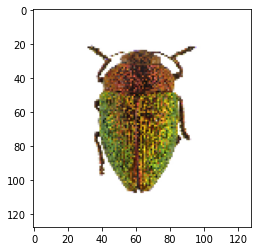

In [105]:
plt.imshow(img)

In [106]:
from sklearn.metrics import classification_report, confusion_matrix

In [108]:
Y_pred = model.predict(test_generator)

In [112]:
Y_pred = np.argmax(Y_pred, axis=1)

In [127]:
print('Confusion Matrix')
cm = (confusion_matrix(test_generator.classes, Y_pred))

Confusion Matrix


In [133]:
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    from https://deeplizard.com/learn/video/km7pxKy4UHU
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  1   1  11   0   4  19]
 [  0   0  11   2   2  19]
 [  4  13  39   2  14  72]
 [  1   1   4   0   1   7]
 [  1   3  16   3   7  34]
 [ 11  11  77   7  43 145]]


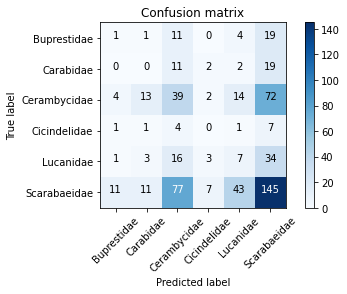

In [134]:
plot_confusion_matrix(cm, classes)

In [121]:
print('Classification Report')
target_names =classes
print(classification_report(test_generator.classes, Y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

 Buprestidae       0.06      0.03      0.04        36
   Carabidae       0.00      0.00      0.00        34
Cerambycidae       0.25      0.27      0.26       144
Cicindelidae       0.00      0.00      0.00        14
   Lucanidae       0.10      0.11      0.10        64
Scarabaeidae       0.49      0.49      0.49       294

    accuracy                           0.33       586
   macro avg       0.15      0.15      0.15       586
weighted avg       0.32      0.33      0.32       586

